In [1]:
## 11/13/15:  add exhibits using problem bank lists
## uses allbanks file for all dates
## this uses modeldata (prior to 1/1/2010), but exhibits should be based on forecasts >1/1/2009
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import random as rd

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
#rk = pd.read_csv("BkAvgAstPR_FailDt_BHC_BkClass_ult2.csv", index_col=0)  # 20160502
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201806.csv", index_col=0)  # 201806
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
rk.head(2)

Rank  IDRSSD      xAsOf                    xName xState   xCert      nAsOf  \
0     1  852218 2018-06-30  JPMORGAN CHASE BANK, NA     OH   628.0 2001-03-31   
1     2  480228 2018-06-30      BANK OF AMERICA, NA     NC  3510.0 2001-03-31   

    FailDate BkClass  Offices    ...           aeTotLn        aeDDep  \
0        NaT       N   5202.0    ...      5.103033e+08  6.666457e+08   
1 2009-01-16       N   4488.0    ...      6.572162e+08  7.949126e+08   

         aeFDep      aeTotDep    pr_eTA   pr_eTAcs    pr_eTL   pr_eTLcs  \
0  2.535391e+08  9.201849e+08  9.193848   9.193848  5.638326   5.638326   
1  1.059607e+08  9.008733e+08  7.896924  17.090772  7.261562  12.899888   

     pr_eDD   pr_eDDcs  
0  7.365749   7.365749  
1  8.782965  16.148713  

[2 rows x 27 columns]

In [3]:
md = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv',index_col=0)
md['AsOf'] = pd.to_datetime(md['AsOf'])
md['FailDate'] = pd.to_datetime(md['FailDate'])
len(md) # 478607

478607

In [4]:
## move later (after subset selected)???
md['xf2_0'] = md.apply(lambda x: -np.log((1/x['f2_0'])-1),axis=1) # logit function (converts pd to z-score)
md['xf4_2'] = md.apply(lambda x: -np.log((1/x['f4_2'])-1),axis=1) # logit function (converts pd to z-score)
md['xf6_4'] = md.apply(lambda x: -np.log((1/x['f6_4'])-1),axis=1) # logit function (converts pd to z-score)
md.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA    ...      Intercept          f2_0  \
0  0.202341  4.771308  2.035791  1.366385    ...            1.0  2.057203e-08   
1  0.199812  4.673793  1.952308  1.314604    ...            1.0  2.345935e-08   

           f2_1          f4_2          f4_3          f6_4      f6_5  \
0  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07  0.000002   
1  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07  0.000002   

       xf2_0      xf4_2      xf6_4  
0 -17.699333 -14.983398 -14.790601  
1 -17.567997 -14.869180 -14.664583  

[2 rows x 36 columns]

In [5]:
md.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5', u'xf2_0',
       u'xf4_2', u'xf6_4'],
      dtype='object')

In [6]:
#### section to process problem bank list 12/31/2010:
pb10 = pd.read_csv('ProbBank20101231.csv',skiprows=3,encoding='latin1')
pb10['Date'] = pd.to_datetime(pb10['Date'])
pb10['Prompt Corrective Action Date'] = pd.to_datetime(pb10['Prompt Corrective Action Date'])
pb10 = pb10.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert')  ## merge IDRSSD from rk table
pb10['pb10'] = 1
pb10.head(2)

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   

                                Name             City State       Date  \
0                  1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1  1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0           Consent Order  Capital                      NaN   
1   Supervisory Agreement  General                      NaN   

  Prompt Corrective Action Date Ticker Symbol    xCert     IDRSSD  pb10  
0                           NaT           CBC  58358.0  3465383.0     1  
1                           NaT           NaN  58773.0  3688678.0     1

In [7]:
pb09 = pd.read_csv('ProbBank100108.csv',skiprows=3,encoding='latin1')
pb09['Date'] = pd.to_datetime(pb09['Date'])
pb09['Prompt Corrective Action Date'] = pd.to_datetime(pb09['Prompt Corrective Action Date'])
pb09 = pb09.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert') ## merge IDRSSD from rk table
pb09['pb09'] = 1
pb09.head(2)

FDIC Cert#  2009q2 Assets $(000s) Class Agency  \
0       15448                  18396    NM   FDIC   
1        1149                 106774    SM    FRB   

                                   Name           City State       Date  \
0  1st American State Bank of Minnesota        Hancock    MN 2008-02-25   
1                    1st Financial Bank  Overland Park    KS 2009-06-22   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0         Cease & Desist   General                      NaN   
1      Written Agreement   General                      NaN   

  Prompt Corrective Action Date Ticker Symbol    xCert     IDRSSD  pb09  
0                           NaT           NaN  15448.0  1006858.0     1  
1                           NaT           NaN   1149.0    50957.0     1

In [8]:
xrng = np.arange(-8,9,1)
xdf=pd.DataFrame(xrng)
xdf.columns = ['x']
xdf['pd'] = xdf.apply(lambda x: 1/(1+np.exp(-x['x'])) ,axis=1)
xdf

x        pd
0  -8  0.000335
1  -7  0.000911
2  -6  0.002473
3  -5  0.006693
4  -4  0.017986
5  -3  0.047426
6  -2  0.119203
7  -1  0.268941
8   0  0.500000
9   1  0.731059
10  2  0.880797
11  3  0.952574
12  4  0.982014
13  5  0.993307
14  6  0.997527
15  7  0.999089
16  8  0.999665

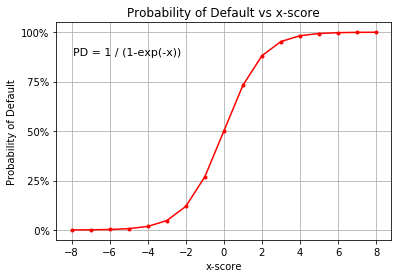

In [10]:
plt.plot(xdf['x'],xdf['pd'],'r-',marker='.')
plt.yticks([0.,.25,.5,.75,1.])
plt.ylabel('Probability of Default')

# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.25)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)

plt.xlabel('x-score')
plt.grid(True)
plt.annotate('PD = 1 / (1-exp(-x))', xy=(0.05, 0.85),\
               xycoords='axes fraction', fontsize=11) # var listing annotation
plt.title('Probability of Default vs x-score')
plt.savefig('PD_vs_xscore'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mdf=md[['AsOf','IDRSSD','f4']].groupby(['f4','AsOf']).count()
mdf=mdf.unstack(0)
mdf.ix['2008':'2010']

IDRSSD       
f4               0      1
AsOf                     
2008-03-31  7496.0   44.0
2008-06-30  7458.0   63.0
2008-09-30  7387.0   99.0
2008-12-31  7315.0  117.0
2009-03-31  7260.0  129.0
2009-06-30  7206.0  137.0
2009-09-30  7149.0  124.0
2009-12-31  7095.0  125.0
2010-03-31  7045.0  106.0
2010-06-30  6965.0   86.0
2010-09-30  6909.0   79.0
2010-12-31  6820.0   77.0

In [12]:
md.head(2),md.tail(2)

(   IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
 0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
 1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
 
     qnTotLn      rNIM     rPPNR      rROA    ...      Intercept          f2_0  \
 0  0.202341  4.771308  2.035791  1.366385    ...            1.0  2.057203e-08   
 1  0.199812  4.673793  1.952308  1.314604    ...            1.0  2.345935e-08   
 
            f2_1          f4_2          f4_3          f6_4      f6_5  \
 0  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07  0.000002   
 1  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07  0.000002   
 
        xf2_0      xf4_2      xf6_4  
 0 -17.699333 -14.983398 -14.790601  
 1 -17.567997 -14.869180 -14.664583  
 
 [2 rows x 36 columns],
          IDRSSD       AsOf                       Name State   eTotAst  \
 489275  5086072 2018-06-30             BLUE GATE BANK    CA  121841.0   
 489281  5143788 2018-

In [13]:
#md09 = md[md['AsOf']>'2008-12-31']
md09 = md[md['AsOf']=='2009-12-31']
md09 = md09.merge(pb09[['IDRSSD','pb09']],how='left',on='IDRSSD')
md09['pb09']=md09['pb09'].fillna(0)
md09 = md09.merge(pb10[['IDRSSD','pb10']],how='left',on='IDRSSD')
md09['pb10']=md09['pb10'].fillna(0)
md09['pb'] = md09.apply(lambda x: max(x['pb09'],x['pb10']),axis=1)
md09['pbf'] = md09.apply(lambda x: max(x['pb09'],x['pb10'],x['f4']),axis=1)
md09['f4j'] = md09.apply(lambda x: x['f4']+rd.gauss(0,.05),axis=1)  ## jitter f4 fail flag
md09.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2009-12-31            BANK OF HANCOCK COUNTY    GA  82141.0   
1     242 2009-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  33370.0   

   rcTotLn   qnTotLn      rNIM     rPPNR      rROA    ...             f6_4  \
0  0.74910  1.610385  3.884223  1.050146  0.732915    ...     2.050603e-07   
1 -0.01406  0.376277  3.932852  1.472476  1.449909    ...     1.098963e-03   

       f6_5      xf2_0      xf4_2      xf6_4  pb09  pb10   pb  pbf       f4j  
0  0.000001 -18.595496 -15.663559 -15.399962   0.0   0.0  0.0  0.0  0.124983  
1  0.001380  -8.889100  -7.482962  -6.812289   0.0   0.0  0.0  0.0 -0.087702  

[2 rows x 41 columns]

In [14]:
pd.DataFrame(md09[['f2','f4','f6','f2_0','f4_2','f6_4','pb09','pb10','pb','pbf']].sum()).to_csv('stats_20091231_prob.csv')
pd.DataFrame(md09[['f2','f4','f6','f2_0','f4_2','f6_4','pb09','pb10','pb','pbf']].sum())

0
f2      66.000000
f4     125.000000
f6     168.000000
f2_0    75.399878
f4_2   154.940632
f6_4   202.804480
pb09   498.000000
pb10   843.000000
pb     987.000000
pbf   1023.000000

In [15]:
len(md09) # 7220

7220

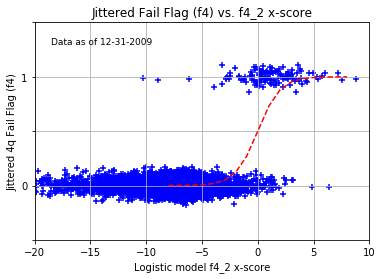

In [16]:
plt.scatter(md09['xf4_2'],md09['f4j'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Jittered Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('Jittered 4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid(True)
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation
#plt.savefig('f4_2xscore_vs_jitteredf4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

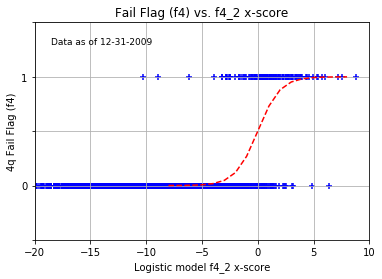

In [17]:
plt.scatter(md09['xf4_2'],md09['f4'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid(True)
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation
#plt.savefig('f4_2xscore_vs_f4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

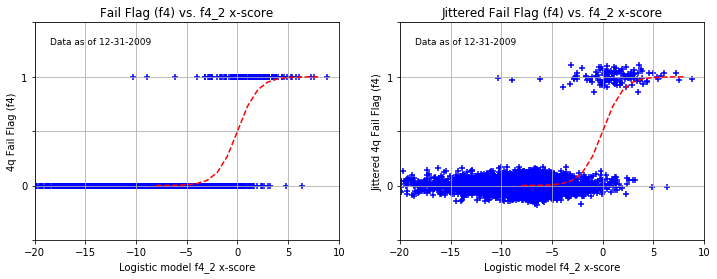

In [18]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

#plt.rcParams.update({'font.size': 4})

plt.subplot(1, 2, 1)
plt.scatter(md09['xf4_2'],md09['f4'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid(True)
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation

plt.subplot(1, 2, 2)
plt.scatter(md09['xf4_2'],md09['f4j'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Jittered Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('Jittered 4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid(True)
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation

plt.savefig('Jittered_and_not_f4_2xscore_vs_f4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
md09.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2009-12-31            BANK OF HANCOCK COUNTY    GA  82141.0   
1     242 2009-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  33370.0   

   rcTotLn   qnTotLn      rNIM     rPPNR      rROA    ...             f6_4  \
0  0.74910  1.610385  3.884223  1.050146  0.732915    ...     2.050603e-07   
1 -0.01406  0.376277  3.932852  1.472476  1.449909    ...     1.098963e-03   

       f6_5      xf2_0      xf4_2      xf6_4  pb09  pb10   pb  pbf       f4j  
0  0.000001 -18.595496 -15.663559 -15.399962   0.0   0.0  0.0  0.0  0.124983  
1  0.001380  -8.889100  -7.482962  -6.812289   0.0   0.0  0.0  0.0 -0.087702  

[2 rows x 41 columns]

In [20]:
md09.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5', u'xf2_0',
       u'xf4_2', u'xf6_4', u'pb09', u'pb10', u'pb', u'pbf', u'f4j'],
      dtype='object')

In [21]:
## criterion for worst4% (>=96th percentile):
## 11/17/15: alter for worst345% for f2,f4,f6 respectively

In [22]:
q2_96=md09['f2_0'].quantile(.96)
q4_96=md09['f4_2'].quantile(.96)
q6_96=md09['f6_4'].quantile(.96)
q2_96, q4_96, q6_96

(0.013688948232187966, 0.065894258893943597, 0.14093463086739999)

In [23]:
## alternative 96ile:
q2_96a=md09[md09['f2']==0]['f2_0'].quantile(.96)
q4_96a=md09[md09['f4']==0]['f4_2'].quantile(.96)
q6_96a=md09[md09['f6']==0]['f6_4'].quantile(.96)
q2_96a, q4_96a, q6_96a

(0.0089711013652812172, 0.032000522968203979, 0.061161006688344011)

In [24]:
## alternative 96ile: 
q2_04a=md09[md09['f2']==1]['f2_0'].quantile(.04)
q4_04a=md09[md09['f4']==1]['f4_2'].quantile(.04)
q6_04a=md09[md09['f6']==1]['f6_4'].quantile(.04)
q2_04a, q4_04a, q6_04a

(0.043242869793020007, 0.040320419604504006, 0.024784870547891195)

In [25]:
## worst 4% summary for 12/31/2009:

In [26]:
sum2PD = [q2_96, q4_96, q6_96]
sum1x =  [-np.log(-1+1/q2_96),-np.log(-1+1/q4_96),-np.log(-1+1/q6_96)]
sum1x, sum2PD

([-4.2773829642799148, -2.6515383257359915, -1.8075488461875824],
 [0.013688948232187966, 0.065894258893943597, 0.14093463086739999])

In [27]:
sum3tot = [md09[md09['f2_0']>q2_96]['f2_0'].count(),md09[md09['f4_2']>q4_96]['f4_2'].count(),\
           md09[md09['f6_4']>q6_96]['f6_4'].count()]
sum3tot

[289, 289, 289]

In [28]:
sum4f = [md09[md09['f2_0']>q2_96]['f2'].sum(),md09[md09['f4_2']>q4_96]['f4'].sum(),\
           md09[md09['f6_4']>q6_96]['f6'].sum()]
sum4f

[64L, 116L, 145L]

In [29]:
sum5pf = [md09[md09['f2_0']>q2_96]['pbf'].sum(),md09[md09['f4_2']>q4_96]['pbf'].sum(),\
           md09[md09['f6_4']>q6_96]['pbf'].sum()]
sum5pf

[266.0, 260.0, 259.0]

In [30]:
## NOTE: error fixes noted below:
sumdf = pd.DataFrame([sum1x,sum2PD,sum3tot,sum4f,sum5pf])
sumdf.columns = ['f2_0','f4_2','f6_4']
sumdf2 = sumdf.T
sumdf2.columns = ['x-score','PD','TotBk','Failed','ProbFailed']
sumdf2['Percentile'] = [96,96,96]
sumdf2['Worst%'] = [4,4,4]
sumdf2 = sumdf2[['Percentile','x-score','PD','Worst%','TotBk','Failed','ProbFailed']]
sumdf2['PD'] = np.round(list(sumdf2['PD']*100),2 )  ## 20160502 (Error with series... added list function)
sumdf2['Fail%'] = np.round(list(sumdf2['Failed'] * 100 / sumdf2['TotBk']),1)  ## 20160502 (... added list function)
sumdf2['ProbFail%'] = np.round(list(sumdf2['ProbFailed'] *100 / sumdf2['TotBk']),1)  ## 20160502 (... added list function)
sumdf2.index.name = 'Model'
sumdf2

Percentile   x-score     PD  Worst%  TotBk  Failed  ProbFailed  Fail%  \
Model                                                                          
f2_0           96 -4.277383   1.37       4  289.0    64.0       266.0   22.1   
f4_2           96 -2.651538   6.59       4  289.0   116.0       260.0   40.1   
f6_4           96 -1.807549  14.09       4  289.0   145.0       259.0   50.2   

       ProbFail%  
Model             
f2_0        92.0  
f4_2        90.0  
f6_4        89.6

In [31]:
sumdf2.to_csv('x96_f246_w4only_stats_20091231.csv')

In [32]:
sum2PD

[0.013688948232187966, 0.065894258893943597, 0.14093463086739999]

In [33]:
md09.tail(2)

IDRSSD       AsOf                             Name State  eTotAst  \
7218  3897434 2009-12-31  BLUE GRASS COMMUNITY BANK, INC.    KY  30202.0   
7219  3900950 2009-12-31                 FIRST GREEN BANK    FL  78690.0   

       rcTotLn  qnTotLn      rNIM      rPPNR       rROA    ...     \
7218  0.012174      0.0  1.828362 -12.743638 -13.948067    ...      
7219  0.007374      0.0  2.145037  -3.574122  -2.912840    ...      

              f6_4          f6_5      xf2_0      xf4_2      xf6_4  pb09  pb10  \
7218  7.937966e-07  3.008122e-07 -20.847747 -17.396073 -14.046438   0.0   0.0   
7219  2.030625e-05  3.309926e-05 -14.187109 -11.863776 -10.804562   0.0   0.0   

       pb  pbf       f4j  
7218  0.0  0.0 -0.004049  
7219  0.0  0.0  0.006970  

[2 rows x 41 columns]

In [34]:
md09.sum()

IDRSSD       7.988801e+09
eTotAst      1.207798e+10
rcTotLn      7.451659e+03
qnTotLn      1.903330e+04
rNIM         2.704397e+04
rPPNR        7.838992e+03
rROA         1.946372e+02
rROE        -9.105043e+03
rEff         8.668006e+06
eLn_Dep      5.654551e+05
aFF_TA       4.432434e+04
eBrok_Dep    3.390717e+04
eT1rb        1.150200e+05
eTotrb       1.234559e+05
eALLL_Ln     1.291852e+04
lnTotAst     8.683855e+04
mtf          4.674856e+03
mtf2         4.687000e+03
f2           6.600000e+01
f4           1.250000e+02
f6           1.680000e+02
f8           2.110000e+02
Intercept    7.220000e+03
f2_0         7.539988e+01
f2_1         7.694328e+01
f4_2         1.549406e+02
f4_3         1.508049e+02
f6_4         2.028045e+02
f6_5         2.075744e+02
xf2_0       -7.117701e+04
xf4_2       -5.823757e+04
xf6_4       -5.316494e+04
pb09         4.980000e+02
pb10         8.430000e+02
pb           9.870000e+02
pbf          1.023000e+03
f4j          1.280476e+02
dtype: float64

In [35]:
#bin = [-100,-75,-50,-25,-20,-15,-12,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,10,12,15,20]
bin = [-100]+ list(np.arange(-25,12,1))
bin = [x-.5 for x in bin]
bin

[-100.5,
 -25.5,
 -24.5,
 -23.5,
 -22.5,
 -21.5,
 -20.5,
 -19.5,
 -18.5,
 -17.5,
 -16.5,
 -15.5,
 -14.5,
 -13.5,
 -12.5,
 -11.5,
 -10.5,
 -9.5,
 -8.5,
 -7.5,
 -6.5,
 -5.5,
 -4.5,
 -3.5,
 -2.5,
 -1.5,
 -0.5,
 0.5,
 1.5,
 2.5,
 3.5,
 4.5,
 5.5,
 6.5,
 7.5,
 8.5,
 9.5,
 10.5]

In [36]:
## assign bins using 12/31/09 data:

In [37]:
md09['bin2'] = pd.cut(md09['xf2_0'],bins=bin)
md09['bin2low'] = md09.apply(lambda x: x['bin2'][1:x['bin2'].index(',')], axis=1)
md09['bin2low'] = md09['bin2low'].convert_objects(convert_numeric=True) + 0.5

md09['bin4'] = pd.cut(md09['xf4_2'],bins=bin)
md09['bin4low'] = md09.apply(lambda x: x['bin4'][1:x['bin4'].index(',')], axis=1)
md09['bin4low'] = md09['bin4low'].convert_objects(convert_numeric=True) + 0.5

md09['bin6'] = pd.cut(md09['xf6_4'],bins=bin)
md09['bin6low'] = md09.apply(lambda x: x['bin6'][1:x['bin6'].index(',')], axis=1)
md09['bin6low'] = md09['bin6low'].convert_objects(convert_numeric=True) + 0.5

md09.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2009-12-31            BANK OF HANCOCK COUNTY    GA  82141.0   
1     242 2009-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  33370.0   

   rcTotLn   qnTotLn      rNIM     rPPNR      rROA   ...    pb10   pb  pbf  \
0  0.74910  1.610385  3.884223  1.050146  0.732915   ...     0.0  0.0  0.0   
1 -0.01406  0.376277  3.932852  1.472476  1.449909   ...     0.0  0.0  0.0   

        f4j            bin2  bin2low            bin4  bin4low            bin6  \
0  0.124983  (-19.5, -18.5]    -19.0  (-16.5, -15.5]    -16.0  (-15.5, -14.5]   
1 -0.087702    (-9.5, -8.5]     -9.0    (-7.5, -6.5]     -7.0    (-7.5, -6.5]   

  bin6low  
0   -15.0  
1    -7.0  

[2 rows x 47 columns]

In [38]:
md09b4a=md09[['bin4low','f4']].groupby('bin4low').count()
md09b4a.rename(columns={'f4':'Totq4'},inplace=True)
md09b4f=md09[['bin4low','f4','f4_2']].groupby(['f4','bin4low']).count()
md09b4f=md09b4f.unstack(0)
md09b4f.columns = ['f40','f41']
md09b4p=md09[['bin4low','pb','f4_2']].groupby(['pb','bin4low']).count()
md09b4p=md09b4p.unstack(0)
md09b4p.columns = ['p0','p1']
md09b4pf=md09[['bin4low','pbf','f4_2']].groupby(['pbf','bin4low']).count()
md09b4pf=md09b4pf.unstack(0)
md09b4pf.columns = ['pf0','pf1']

md09b4m = pd.concat([md09b4a,md09b4f,md09b4p,md09b4pf],axis=1)
md09b4m = md09b4m.fillna(0)
md09b4m['bin'] = md09b4m.index.astype(float)
md09b4m['PD'] = md09b4m.apply(lambda x:1/(1+np.exp(-x['bin'])),axis=1)
md09b4m.sum()

Totq4    7220.000000
f40      7095.000000
f41       125.000000
p0       6233.000000
p1        987.000000
pf0      6197.000000
pf1      1023.000000
bin      -380.000000
PD          9.500072
dtype: float64

In [39]:
md09b4m[-12:-6]

Totq4     f40  f41      p0     p1     pf0    pf1   bin        PD
bin4low                                                                  
-12.0      195   195.0  0.0   192.0    3.0   192.0    3.0 -12.0  0.000006
-11.0      281   281.0  0.0   276.0    5.0   276.0    5.0 -11.0  0.000017
-10.0      404   403.0  1.0   399.0    5.0   398.0    6.0 -10.0  0.000045
-9.0       679   678.0  1.0   659.0   20.0   658.0   21.0  -9.0  0.000123
-8.0      1095  1095.0  0.0  1047.0   48.0  1047.0   48.0  -8.0  0.000335
-7.0      1566  1566.0  0.0  1469.0   97.0  1469.0   97.0  -7.0  0.000911
-6.0      1276  1275.0  1.0  1103.0  173.0  1102.0  174.0  -6.0  0.002473

In [40]:
md09b2a=md09[['bin2low','f2']].groupby('bin2low').count()
md09b2a.rename(columns={'f2':'Totq2'},inplace=True)
md09b2f=md09[['bin2low','f2','f2_0']].groupby(['f2','bin2low']).count()
md09b2f=md09b2f.unstack(0)
md09b2f.columns = ['f20','f21']
md09b2p=md09[['bin2low','pb','f2_0']].groupby(['pb','bin2low']).count()
md09b2p=md09b2p.unstack(0)
md09b2p.columns = ['p0','p1']
md09b2pf=md09[['bin2low','pbf','f2_0']].groupby(['pbf','bin2low']).count()
md09b2pf=md09b2pf.unstack(0)
md09b2pf.columns = ['pf0','pf1']

md09b2m = pd.concat([md09b2a,md09b2f,md09b2p,md09b2pf],axis=1)
md09b2m = md09b2m.fillna(0)
md09b2m['bin'] = md09b2m.index.astype(float)
md09b2m['PD'] = md09b2m.apply(lambda x:1/(1+np.exp(-x['bin'])),axis=1)
md09b2m.sum()

Totq2    7220.000000
f20      7154.000000
f21        66.000000
p0       6233.000000
p1        987.000000
pf0      6197.000000
pf1      1023.000000
bin      -404.000000
PD          6.501442
dtype: float64

In [41]:
md09b2m[-12:-6]

Totq2     f20  f21      p0     p1     pf0    pf1   bin        PD
bin2low                                                                  
-12.0      329   328.0  1.0   322.0    7.0   321.0    8.0 -12.0  0.000006
-11.0      523   522.0  1.0   509.0   14.0   508.0   15.0 -11.0  0.000017
-10.0      831   831.0  0.0   789.0   42.0   789.0   42.0 -10.0  0.000045
-9.0      1160  1160.0  0.0  1095.0   65.0  1095.0   65.0  -9.0  0.000123
-8.0      1559  1559.0  0.0  1427.0  132.0  1426.0  133.0  -8.0  0.000335
-7.0       941   941.0  0.0   738.0  203.0   738.0  203.0  -7.0  0.000911
-6.0       323   323.0  0.0   177.0  146.0   177.0  146.0  -6.0  0.002473

In [42]:
md09b6a=md09[['bin6low','f6']].groupby('bin6low').count()
md09b6a.rename(columns={'f6':'Totq6'},inplace=True)
md09b6f=md09[['bin6low','f6','f6_4']].groupby(['f6','bin6low']).count()
md09b6f=md09b6f.unstack(0)
md09b6f.columns = ['f60','f61']
md09b6p=md09[['bin6low','pb','f6_4']].groupby(['pb','bin6low']).count()
md09b6p=md09b6p.unstack(0)
md09b6p.columns = ['p0','p1']
md09b6pf=md09[['bin6low','pbf','f6_4']].groupby(['pbf','bin6low']).count()
md09b6pf=md09b6pf.unstack(0)
md09b6pf.columns = ['pf0','pf1']

md09b6m = pd.concat([md09b6a,md09b6f,md09b6p,md09b6pf],axis=1)
md09b6m = md09b6m.fillna(0)
md09b6m['bin'] = md09b6m.index.astype(float)
md09b6m['PD'] = md09b6m.apply(lambda x:1/(1+np.exp(-x['bin'])),axis=1)
md09b6m.sum()

Totq6    7220.000000
f60      7052.000000
f61       168.000000
p0       6233.000000
p1        987.000000
pf0      6197.000000
pf1      1023.000000
bin      -389.000000
PD          8.500195
dtype: float64

In [43]:
md09b4m

Totq4     f40   f41      p0     p1     pf0    pf1    bin  \
bin4low                                                             
-100.0      81    81.0   0.0    79.0    2.0    79.0    2.0 -100.0   
-25.0        6     6.0   0.0     6.0    0.0     6.0    0.0  -25.0   
-24.0        4     4.0   0.0     4.0    0.0     4.0    0.0  -24.0   
-23.0       15    15.0   0.0    15.0    0.0    15.0    0.0  -23.0   
-22.0        9     9.0   0.0     9.0    0.0     9.0    0.0  -22.0   
-21.0       13    13.0   0.0    13.0    0.0    13.0    0.0  -21.0   
-20.0       15    15.0   0.0    15.0    0.0    15.0    0.0  -20.0   
-19.0       27    27.0   0.0    27.0    0.0    27.0    0.0  -19.0   
-18.0       24    24.0   0.0    24.0    0.0    24.0    0.0  -18.0   
-17.0       36    36.0   0.0    36.0    0.0    36.0    0.0  -17.0   
-16.0       49    49.0   0.0    47.0    2.0    47.0    2.0  -16.0   
-15.0       59    59.0   0.0    58.0    1.0    58.0    1.0  -15.0   
-14.0      115   115.0   0.0   113.0    2.0   113.0    2.0  -14.0   
-13.0      126   126.0   0.0   125.0    1.0   125.0    1.0  -13.0   
-12.0      195   195.0   0.0   192.0    3.0   192.0    3.0  -12.0   
-11.0      281   281.0   0.0   276.0    5.0   276.0    5.0  -11.0   
-10.0      404   403.0   1.0   399.0    5.0   398.0    6.0  -10.0   
-9.0       679   678.0   1.0   659.0   20.0   658.0   21.0   -9.0   
-8.0      1095  1095.0   0.0  1047.0   48.0  1047.0   48.0   -8.0   
-7.0      1566  1566.0   0.0  1469.0   97.0  1469.0   97.0   -7.0   
-6.0      1276  1275.0   1.0  1103.0  173.0  1102.0  174.0   -6.0   
-5.0       497   497.0   0.0   316.0  181.0   316.0  181.0   -5.0   
-4.0       231   230.0   1.0   101.0  130.0   101.0  130.0   -4.0   
-3.0       144   136.0   8.0    46.0   98.0    44.0  100.0   -3.0   
-2.0        67    63.0   4.0    13.0   54.0    10.0   57.0   -2.0   
-1.0        51    43.0   8.0     9.0   42.0     7.0   44.0   -1.0   
 0.0        51    23.0  28.0     8.0   43.0     2.0   49.0    0.0   
 1.0        44    20.0  24.0     8.0   36.0     1.0   43.0    1.0   
 2.0        22     6.0  16.0     7.0   15.0     1.0   21.0    2.0   
 3.0        19     3.0  16.0     4.0   15.0     2.0   17.0    3.0   
 4.0         8     0.0   8.0     4.0    4.0     0.0    8.0    4.0   
 5.0         5     1.0   4.0     1.0    4.0     0.0    5.0    5.0   
 6.0         3     1.0   2.0     0.0    3.0     0.0    3.0    6.0   
 7.0         1     0.0   1.0     0.0    1.0     0.0    1.0    7.0   
 8.0         1     0.0   1.0     0.0    1.0     0.0    1.0    8.0   
 9.0         1     0.0   1.0     0.0    1.0     0.0    1.0    9.0   

                   PD  
bin4low                
-100.0   3.720076e-44  
-25.0    1.388794e-11  
-24.0    3.775135e-11  
-23.0    1.026188e-10  
-22.0    2.789468e-10  
-21.0    7.582560e-10  
-20.0    2.061154e-09  
-19.0    5.602796e-09  
-18.0    1.522998e-08  
-17.0    4.139938e-08  
-16.0    1.125352e-07  
-15.0    3.059022e-07  
-14.0    8.315280e-07  
-13.0    2.260324e-06  
-12.0    6.144175e-06  
-11.0    1.670142e-05  
-10.0    4.539787e-05  
-9.0     1.233946e-04  
-8.0     3.353501e-04  
-7.0     9.110512e-04  
-6.0     2.472623e-03  
-5.0     6.692851e-03  
-4.0     1.798621e-02  
-3.0     4.742587e-02  
-2.0     1.192029e-01  
-1.0     2.689414e-01  
 0.0     5.000000e-01  
 1.0     7.310586e-01  
 2.0     8.807971e-01  
 3.0     9.525741e-01  
 4.0     9.820138e-01  
 5.0     9.933071e-01  
 6.0     9.975274e-01  
 7.0     9.990889e-01  
 8.0     9.996646e-01  
 9.0     9.998766e-01

In [44]:
q4_96,-np.log(-1+1/q4_96)

(0.065894258893943597, -2.6515383257359915)

In [45]:
q96 = -np.log(-1+1/q4_96)
q96

-2.6515383257359915

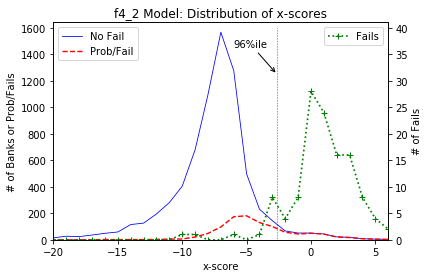

In [46]:
mdg4 = md09b4m
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index)
ax1 = plt.gca()
ax1.plot(mdx4, mdg4['Totq4'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx4, mdg4['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96,q96],[0,1600],'k:',lw=.6)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1640])
ax1.annotate('96%ile', xy=(q96,1250), xytext=(-6,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx4, mdg4['f41'], 'g:',marker='+',lw=1.7, label='Fails')
ax2.set_ylim([0,41])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f4_2 Model: Distribution of x-scores')
#plt.savefig('Worst4_f4_2_nbrbankfailprob'+'.png', dpi=300, bbox_inches='tight')
plt.show()

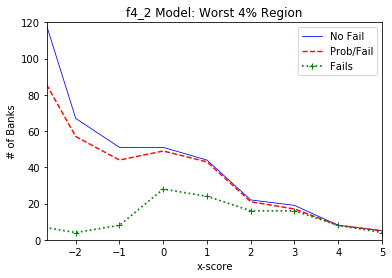

In [47]:
mdg4 = md09b4m.ix[-3:5]
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index)
plt.plot(mdx4, mdg4['Totq4'],'b-',lw=.8, label='No Fail')
plt.plot(mdx4, mdg4['pf1'],  'r--',lw=1.4, label='Prob/Fail')
plt.plot(mdx4, mdg4['f41'],'g:',marker='+',lw=1.7, label='Fails')
plt.legend(loc=0)
plt.xlim([q96,5])   # q96 is -2.6 x-score
plt.xlabel('x-score')
plt.ylim([0,120])
plt.ylabel('# of Banks')
plt.title('f4_2 Model: Worst 4% Region')
plt.savefig('Worst4only_f4_2_nbrbankfailprob'+'.png', dpi=300, bbox_inches='tight')
plt.show()

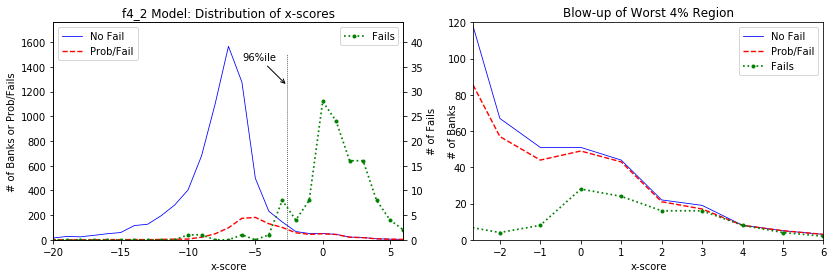

In [48]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
mdg4 = md09b4m
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx4, mdg4['Totq4'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx4, mdg4['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96,q96],[0,1500],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])
ax1.annotate('96%ile', xy=(q96,1250), xytext=(-6,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx4, mdg4['f41'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f4_2 Model: Distribution of x-scores')

plt.subplot(1, 2, 2)
mdg4 = md09b4m.ix[-3:6]
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx4, mdg4['Totq4'],'b-',lw=.8, label='No Fail')
ax1.plot(mdx4, mdg4['pf1'],  'r--',lw=1.4, label='Prob/Fail')
ax1.plot(mdx4, mdg4['f41'],'g:',marker='.',lw=1.7, label='Fails')
ax1.legend(loc=0)
ax1.set_xlim([q96,6])   # q96 is -2.6 x-score
ax1.set_xlabel('x-score')
ax1.set_ylim([0,120])
ax1.set_ylabel('# of Banks')
ax1.yaxis.set_label_coords(-.045, .5)
plt.title('Blow-up of Worst 4% Region')

plt.savefig('Worst4only_f4_2_fulldist_nbrbankfailprob'+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [49]:
q96f2 = -np.log(-1+1/q2_96)
q2_96, q96f2

(0.013688948232187966, -4.2773829642799148)

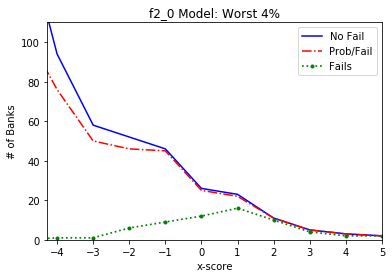

In [50]:
mdg2 = md09b2m.ix[-5:6]
mdg2.fillna(0, inplace=True)
mdx2 = list(mdg2.index)
plt.plot(mdx2, mdg2['Totq2'], 'b-', label='No Fail')
plt.plot(mdx2, mdg2['pf1'], 'r-.',lw=1.5, label='Prob/Fail')
plt.plot(mdx2, mdg2['f21'],'g:',marker='.',lw=1.7, label='Fails')
plt.legend(loc=0)
plt.xticks(np.arange(-5,6,1))
plt.xlim([q96f2,5])   
plt.xlabel('x-score')
plt.ylim([0,110])
plt.ylabel('# of Banks')
plt.title('f2_0 Model: Worst 4%')
plt.savefig('Worst4only_f2_0_nbrbankfailprob'+'.png', dpi=300, bbox_inches='tight')
plt.show()

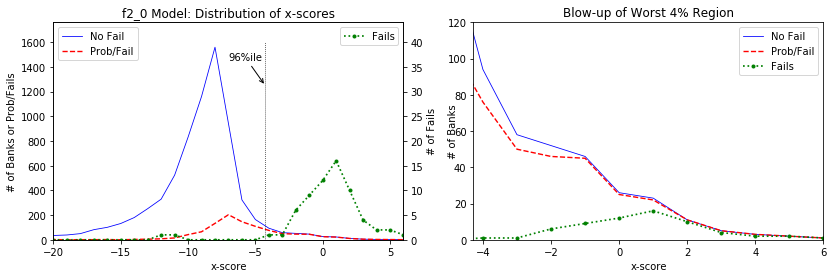

In [51]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
mdg2 = md09b2m
mdg2.fillna(0, inplace=True)
mdx2 = list(mdg2.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx2, mdg2['Totq2'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx2, mdg2['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96f2,q96f2],[0,1600],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])
ax1.annotate('96%ile', xy=(q96f2,1250), xytext=(-7,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx2, mdg2['f21'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f2_0 Model: Distribution of x-scores')

plt.subplot(1, 2, 2)
mdg2 = md09b2m.ix[-5:6]
mdg2.fillna(0, inplace=True)
mdx2 = list(mdg2.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx2, mdg2['Totq2'],'b-',lw=.8, label='No Fail')
ax1.plot(mdx2, mdg2['pf1'],  'r--',lw=1.4, label='Prob/Fail')
ax1.plot(mdx2, mdg2['f21'],'g:',marker='.',lw=1.7, label='Fails')
ax1.legend(loc=0)
ax1.set_xlim([q96f2,6])   # q96 is -2.6 x-score
ax1.set_xlabel('x-score')
ax1.set_ylim([0,120])
ax1.set_ylabel('# of Banks')
ax1.yaxis.set_label_coords(-.045, .5)
plt.title('Blow-up of Worst 4% Region')

plt.savefig('Worst4only_f2_0_fulldist_nbrbankfailprob'+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [52]:
q96f6 = -np.log(-1+1/q6_96)
q6_96, q96f6

(0.14093463086739999, -1.8075488461875824)

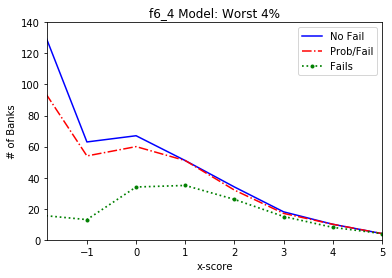

In [53]:
mdg6 = md09b6m.ix[-3:6]
mdg6.fillna(0, inplace=True)
mdx6 = list(mdg6.index)
plt.plot(mdx6, mdg6['Totq6'], 'b-', label='No Fail')
plt.plot(mdx6, mdg6['pf1'], 'r-.',lw=1.5, label='Prob/Fail')
plt.plot(mdx6, mdg6['f61'],'g:',marker='.',lw=1.7, label='Fails')
plt.legend(loc=0)
plt.xticks(np.arange(-3,6,1))
plt.xlim([q96f6,5])   
plt.xlabel('x-score')
plt.ylim([0,140])
plt.ylabel('# of Banks')
plt.title('f6_4 Model: Worst 4%')
plt.savefig('Worst4only_f6_4_nbrbankfailprob'+'.png', dpi=300, bbox_inches='tight')
plt.show()

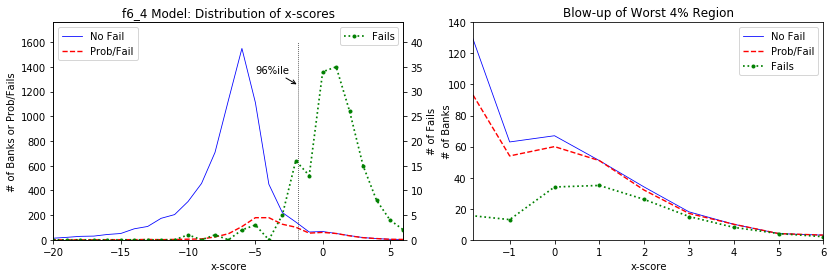

In [54]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
mdg6 = md09b6m
mdg6.fillna(0, inplace=True)
mdx6 = list(mdg6.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx6, mdg6['Totq6'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx6, mdg6['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96f6,q96f6],[0,1600],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])
ax1.annotate('96%ile', xy=(q96f6,1250), xytext=(-5,1350),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx6, mdg6['f61'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f6_4 Model: Distribution of x-scores')

plt.subplot(1, 2, 2)
mdg6 = md09b6m.ix[-3:6]
mdg6.fillna(0, inplace=True)
mdx6 = list(mdg6.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx6, mdg6['Totq6'],'b-',lw=.8, label='No Fail')
ax1.plot(mdx6, mdg6['pf1'],  'r--',lw=1.4, label='Prob/Fail')
ax1.plot(mdx6, mdg6['f61'],'g:',marker='.',lw=1.7, label='Fails')
ax1.legend(loc=0)
ax1.set_xlim([q96f6,6])   # q96 is -2.6 x-score
ax1.set_xlabel('x-score')
ax1.set_ylim([0,140])
ax1.set_ylabel('# of Banks')
ax1.yaxis.set_label_coords(-.06, .5)
plt.title('Blow-up of Worst 4% Region')

plt.savefig('Worst4only_f6_4_fulldist_nbrbankfailprob'+'.png', dpi=400, bbox_inches='tight')
plt.show()

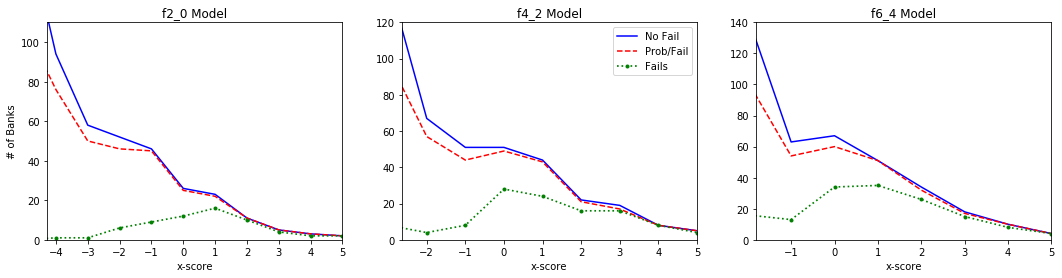

In [55]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
mdg2 = md09b2m.ix[-5:6]
mdg2.fillna(0, inplace=True)
mdx2 = list(mdg2.index)
plt.plot(mdx2, mdg2['Totq2'], 'b-', label='No Fail')
plt.plot(mdx2, mdg2['pf1'], 'r--',lw=1.5, label='Prob/Fail')
plt.plot(mdx2, mdg2['f21'], 'g:',marker='.',lw=1.7, label='Fails')
#plt.legend(loc=0)
plt.xticks(np.arange(-4,6,1))
plt.xlim([q96f2,5])   
plt.xlabel('x-score')
plt.ylim([0,110])
plt.ylabel('# of Banks')
plt.title('f2_0 Model')

plt.subplot(1, 3, 2)
mdg4 = md09b4m.ix[-3:5]
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index)
plt.plot(mdx4, mdg4['Totq4'], 'b-', label='No Fail')
plt.plot(mdx4, mdg4['pf1'], 'r--',lw=1.5, label='Prob/Fail')
plt.plot(mdx4, mdg4['f41'],'g:',marker='.',lw=1.7, label='Fails')
plt.legend(loc=0)
plt.xlim([q96,5])   # q96 is -2.6 x-score
plt.xlabel('x-score')
plt.ylim([0,120])
#plt.ylabel('# of Banks')
plt.title('f4_2 Model')

plt.subplot(1, 3, 3)
mdg6 = md09b6m.ix[-3:6]
mdg6.fillna(0, inplace=True)
mdx6 = list(mdg6.index)
plt.plot(mdx6, mdg6['Totq6'], 'b-', label='Total #')
plt.plot(mdx6, mdg6['pf1'], 'r--',lw=1.5, label='Prob/Fail')
plt.plot(mdx6, mdg6['f61'], 'g:',marker='.',lw=1.7, label='Fails')
#plt.legend(loc=0)
plt.xticks(np.arange(-3,6,1))
plt.xlim([q96f6,5])   
plt.xlabel('x-score')
plt.ylim([0,140])
#plt.ylabel('# of Banks')
plt.title('f6_4 Model')
plt.savefig('x96_f246_w4onlyblowup_nbrbankfailprob_xscore'+'.png', dpi=400, bbox_inches='tight')
plt.show()

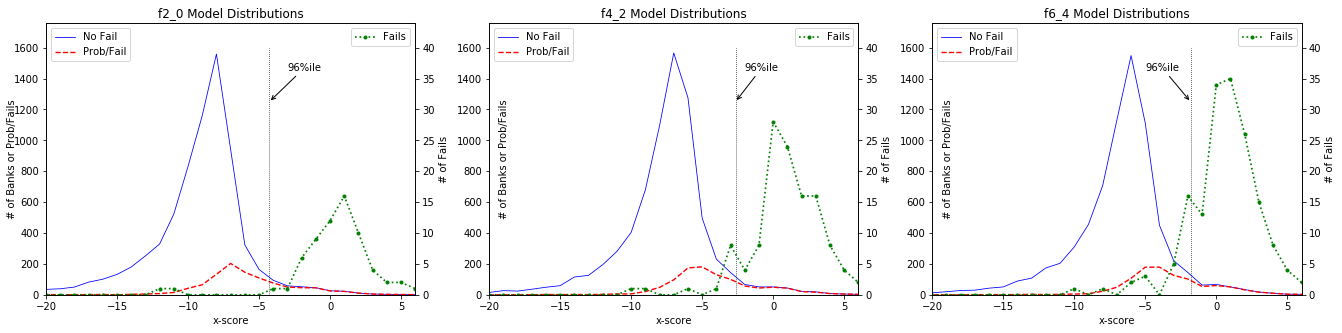

In [56]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3.75, plSize[1]*1.25) )  ## double width, single height

plt.subplot(1, 3, 1)
mdg2 = md09b2m
mdg2.fillna(0, inplace=True)
mdx2 = list(mdg2.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx2, mdg2['Totq2'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx2, mdg2['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96f2,q96f2],[0,1600],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])  # 1760, 1320
ax1.yaxis.set_label_coords(-.078, .5)
ax1.annotate('96%ile', xy=(q96f2,1250), xytext=(-3,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx2, mdg2['f21'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f2_0 Model Distributions')


plt.subplot(1, 3, 2)
mdg4 = md09b4m
mdg4.fillna(0, inplace=True)
mdx4 = list(mdg4.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx4, mdg4['Totq4'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx4, mdg4['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96,q96],[0,1600],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])
ax1.yaxis.set_label_coords(.055, .5)
ax1.annotate('96%ile', xy=(q96,1250), xytext=(-2,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx4, mdg4['f41'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f4_2 Model Distributions')

plt.subplot(1, 3, 3)
mdg6 = md09b6m
mdg6.fillna(0, inplace=True)
mdx6 = list(mdg6.index.astype(float))
ax1 = plt.gca()
ax1.plot(mdx6, mdg6['Totq6'], 'b-',lw=.8, label='No Fail')
ax1.plot(mdx6, mdg6['pf1'], 'r--',lw=1.4, label='Prob/Fail')
ax1.plot([q96f6,q96f6],[0,1600],'k:',lw=.75)
ax1.legend(loc=2)
ax1.set_xlim([-20,6])   # q96 is -2.6 x-score
ax1.set_ylabel('# of Banks or Prob/Fails')
ax1.set_ylim([0,1760])
ax1.yaxis.set_label_coords(.055, .5)  #  (-.078, .5)
ax1.annotate('96%ile', xy=(q96f6,1250), xytext=(-5,1450),
            arrowprops=dict(arrowstyle = '->'))

plt.xlabel('x-score')

ax2 = ax1.twinx()
ax2.plot(mdx6, mdg6['f61'], 'g:',marker='.',lw=1.7, label='Fails')
ax2.set_ylim([0,44])
ax2.set_xlim([-20,6])   # q96 is -2.6 x-score
ax2.legend(loc=1)
ax2.set_ylabel('# of Fails')

plt.title('f6_4 Model Distributions')
plt.savefig('x96_f246_w4onlyfulldist_nbrbankfailprob_xscore'+'.png', dpi=400, bbox_inches='tight')
plt.show()